# Predictive Modeling
### Using Naive Bayes, Decision Tree, Random Forest, and SVM
- **The first step is to import necessary libraries.**

In [97]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore tensorflow warnings (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load DataFrame

In [98]:
# uncomment to load
with gzip.open('data/poetry_all_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [99]:
df.genre.unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'fugitive', 'georgian', 'harlem_renaissance', 'imagist',
       'language_poetry', 'modern', 'new_york_school',
       'new_york_school_2nd_generation', 'objectivist', 'romantic',
       'victorian'], dtype=object)

In [100]:
df = df[(df.genre != 'fugitive') & (df.genre != 'georgian')]
df.reset_index(drop=True, inplace=True)
df.genre.unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'harlem_renaissance', 'imagist', 'language_poetry', 'modern',
       'new_york_school', 'new_york_school_2nd_generation', 'objectivist',
       'romantic', 'victorian'], dtype=object)

In [101]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [102]:
# check out the class balance
df.genre.value_counts(normalize=True)

modern                            0.292276
victorian                         0.146938
romantic                          0.090951
imagist                           0.081353
new_york_school                   0.060329
black_mountain                    0.058729
language_poetry                   0.043876
new_york_school_2nd_generation    0.043876
confessional                      0.040219
black_arts_movement               0.037706
objectivist                       0.036335
harlem_renaissance                0.033821
beat                              0.033592
Name: genre, dtype: float64

- **Classes are fairly balanced.**

### Create features and target dataframes

In [103]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df['genre']

### Train-Test Split

In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3282, 8) (3282,)
(1094, 8) (1094,)


## Baseline model -- tf-idf vectors only

In [9]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [10]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [11]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

CPU times: user 3.87 s, sys: 456 ms, total: 4.33 s
Wall time: 3.9 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [12]:
%%time

# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.40067032297379646
F1 score: 0.3232331421015949

-----TEST-----
Accuracy: 0.34186471663619744
F1 score: 0.21982686628057485

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.50      0.03      0.05        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.00      0.00      0.00        64
                  confessional       0.00      0.00      0.00        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        modern       0.32      0.96      0.48       320
               new_york_school       0.60      0.05      0.08        66
new_york_school_2nd_gener

- **Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.**
- **That said, it is indeed overpredicting on 'modern'.**

### Feature importances

- **Code modified from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes**

In [13]:
# assign the top 10 feature importances for each class
metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [14]:
# match them up with the proper label
print(np.take(X_train_vec.columns, metro_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, modern_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, avant_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, pre1900_class_prob_sorted[:10]))

Index(['abbey', 'abash', 'abbadabba', 'abandonment', 'abate', 'aaron', 'abase',
       'abates', 'abacus', 'aalto'],
      dtype='object')
Index(['aaa', 'pediment', 'pedigree', 'pedicure', 'pedestalled', 'pedestal',
       'pederasty', 'peddler', 'peddle', 'pedantry'],
      dtype='object')
Index(['aaa', 'permanence', 'perked', 'periwinkle', 'periwig', 'peritonitis',
       'perishable', 'peripatetic', 'periodically', 'periodic'],
      dtype='object')
Index(['aaa', 'parthian', 'parthenope', 'parthenon', 'parterre', 'partan',
       'partaker', 'partake', 'parson', 'parsley'],
      dtype='object')


## Baseline model -- vectors + numerical data

- **Create dataframe.**

In [15]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

- **Scale and combine.**

In [16]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [17]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

- **Model.**

In [18]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

CPU times: user 7.89 s, sys: 1.34 s, total: 9.22 s
Wall time: 8.76 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [19]:
%%time

# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.40097501523461304
F1 score: 0.323810594335143

-----TEST-----
Accuracy: 0.34277879341864714
F1 score: 0.2207823088361969

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.50      0.03      0.05        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.00      0.00      0.00        64
                  confessional       0.00      0.00      0.00        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        modern       0.32      0.96      0.48       320
               new_york_school       0.60      0.05      0.08        66
new_york_school_2nd_generat

- **Practically the same result.**

### Feature importances

In [20]:
# # assign the top 10 feature importances for each class
# metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
# modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
# avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
# pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [21]:
# # match them up with the proper label
# print(np.take(X_train_combo.columns, metro_class_prob_sorted[:10]))
# print(np.take(X_train_combo.columns, modern_class_prob_sorted[:10]))
# print(np.take(X_train_combo.columns, avant_class_prob_sorted[:10]))
# print(np.take(X_train_combo.columns, pre1900_class_prob_sorted[:10]))

- **Some engineered features made it into this one.**

## Decision Tree -- tf-idf vectors only

- **I'll first take a quick look at cross validation scores.**

In [22]:
# instantiate the naive bayes classifier
tree_vec = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.25531915, 0.23708207, 0.25      , 0.22256098, 0.25609756,
       0.21341463, 0.24085366, 0.24695122, 0.22865854, 0.27134146])

- **Naive Bayes performs better.**

## Decision Tree -- vectors and numerical data

- **Look at cross validation scores.**

In [23]:
# instantiate the decision tree classifier
tree_combo = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.26443769, 0.25531915, 0.30182927, 0.27743902, 0.29268293,
       0.26829268, 0.29268293, 0.28353659, 0.27743902, 0.30792683])

- **A notable improvement, so I'll fit a model.**

In [24]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 9.29 s, sys: 1.07 s, total: 10.4 s
Wall time: 10.4 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [25]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 0.9996953077391835
F1 score: 0.999695755417307

-----TEST-----
Accuracy: 0.27148080438756855
F1 score: 0.2711428355205478

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.15      0.16      0.15        37
           black_arts_movement       0.09      0.07      0.08        41
                black_mountain       0.21      0.20      0.21        64
                  confessional       0.10      0.09      0.10        44
            harlem_renaissance       0.15      0.16      0.16        37
                       imagist       0.23      0.22      0.23        89
               language_poetry       0.20      0.21      0.20        48
                        modern       0.38      0.38      0.38       320
               new_york_school       0.21      0.26      0.23        66
new_york_school_2nd_generati

- **This is definitely better than our Naive Bayes model.**
    - **It predicts 'modern' a lot less.**
    - **Predictions seem fairly evenly spread.**
    - **Has trouble predicting avant-garde.**
    
### Feature importances

In [26]:
# create a dictionary
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))

# sort dictionary
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'avg_len_line': 0.05038841404758135,
 'avg_syllables_word': 0.04736964269542091,
 'num_lines': 0.04229882958135883,
 'num_end_rhymes': 0.03319434512464857,
 'sentiment_polarity_score': 0.03199025256131939,
 'sentiment_subjectivity_score': 0.031572919424001256,
 'come': 0.01548793327749331,
 'love': 0.007303207632053577,
 'black': 0.007204232361671948,
 'god': 0.0065908949835707725}

- **Mostly engineered features on top.**

## Random Forest -- tf-idf vectors only

- **First, I'll take a quick look at cross validation scores.**

In [27]:
%%time

# instantiate the rf classifier
forest_vec = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.3768997 , 0.37082067, 0.37804878, 0.35365854, 0.36280488,
       0.34146341, 0.35365854, 0.37195122, 0.36890244, 0.375     ])

- **Compare that to vectors plus numerical data.**

## Random Forest -- vectors and numerical data

- **Take a quick look at cross validation scores.**

In [28]:
%%tim

# instantiate the rf classifier
forest_combo = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.39513678, 0.39209726, 0.40853659, 0.38414634, 0.4054878 ,
       0.39329268, 0.36890244, 0.3902439 , 0.36890244, 0.39939024])

- **Including engineered features seems more promising, so I'll move ahead with this one.**

In [29]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(class_weight='balanced', random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 21.6 s, sys: 1.04 s, total: 22.7 s
Wall time: 22.7 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [30]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 0.9996953077391835
F1 score: 0.999695755417307

-----TEST-----
Accuracy: 0.3903107861060329
F1 score: 0.29734738769216884

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       1.00      0.05      0.10        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.83      0.08      0.14        64
                  confessional       0.67      0.05      0.09        44
            harlem_renaissance       1.00      0.05      0.10        37
                       imagist       1.00      0.10      0.18        89
               language_poetry       0.00      0.00      0.00        48
                        modern       0.33      0.98      0.50       320
               new_york_school       1.00      0.02      0.03        66
new_york_school_2nd_generati

- **Good results! So I'll look at a confusion matrix visualization.**

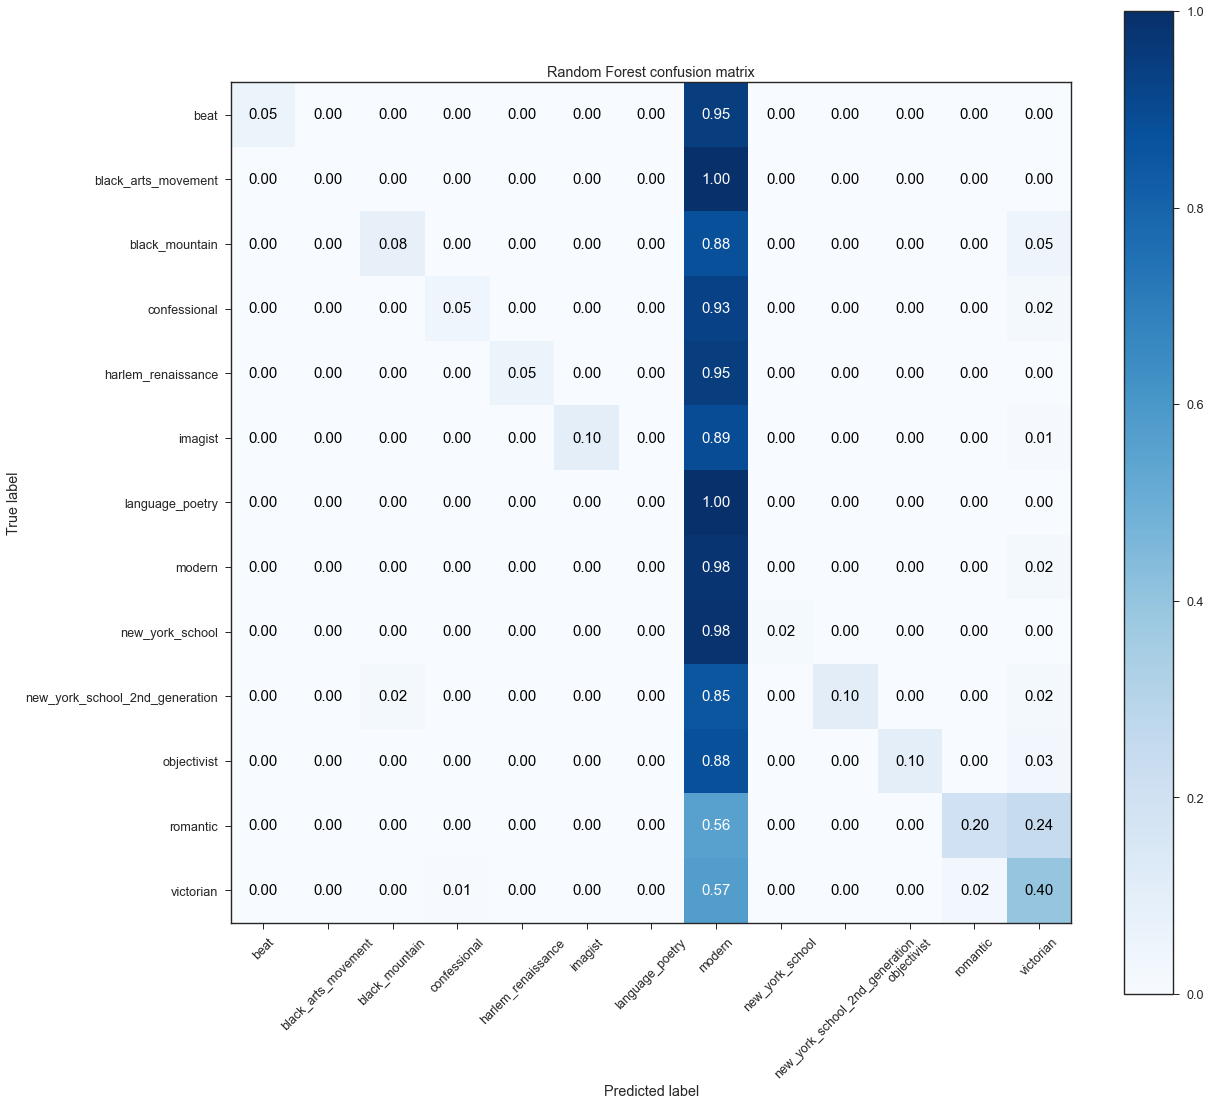

In [31]:
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Big strides made on all categories here.**
- **Looks like some improvement could be made for avant-garde and metropolitan.**

### Feature importances

In [32]:
# create a dictionary
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))

# sort dictionary
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'avg_len_line': 0.010542853418491115,
 'num_end_rhymes': 0.010087477572465564,
 'avg_syllables_word': 0.008935075832598866,
 'num_lines': 0.006821399953804129,
 'sentiment_polarity_score': 0.005994227059446993,
 'sentiment_subjectivity_score': 0.005581309558552357,
 'love': 0.002574070091900374,
 'one': 0.002496363262018933,
 'say': 0.0024703241504733385,
 'day': 0.0023609844085520225}

- **Lots of engineered features here, and some surprise words.**
- **'Heart' appeared to be mostly within pre-1900 poetry, so that probably explains it's importance.**

## SVM Model - tf-idf vectors only

In [33]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 15min 7s, sys: 2.81 s, total: 15min 10s
Wall time: 15min 12s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
%%time

# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.9564290067032297
F1 score: 0.9560430001773105

-----TEST-----
Accuracy: 0.5274223034734917
F1 score: 0.5098719736782823

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.46      0.30      0.36        37
           black_arts_movement       0.38      0.15      0.21        41
                black_mountain       0.46      0.41      0.43        64
                  confessional       0.45      0.20      0.28        44
            harlem_renaissance       0.64      0.24      0.35        37
                       imagist       0.57      0.53      0.55        89
               language_poetry       0.41      0.19      0.26        48
                        modern       0.49      0.76      0.60       320
               new_york_school       0.43      0.50      0.46        66
new_york_school_2nd_generati

### Confusion matrix visualization

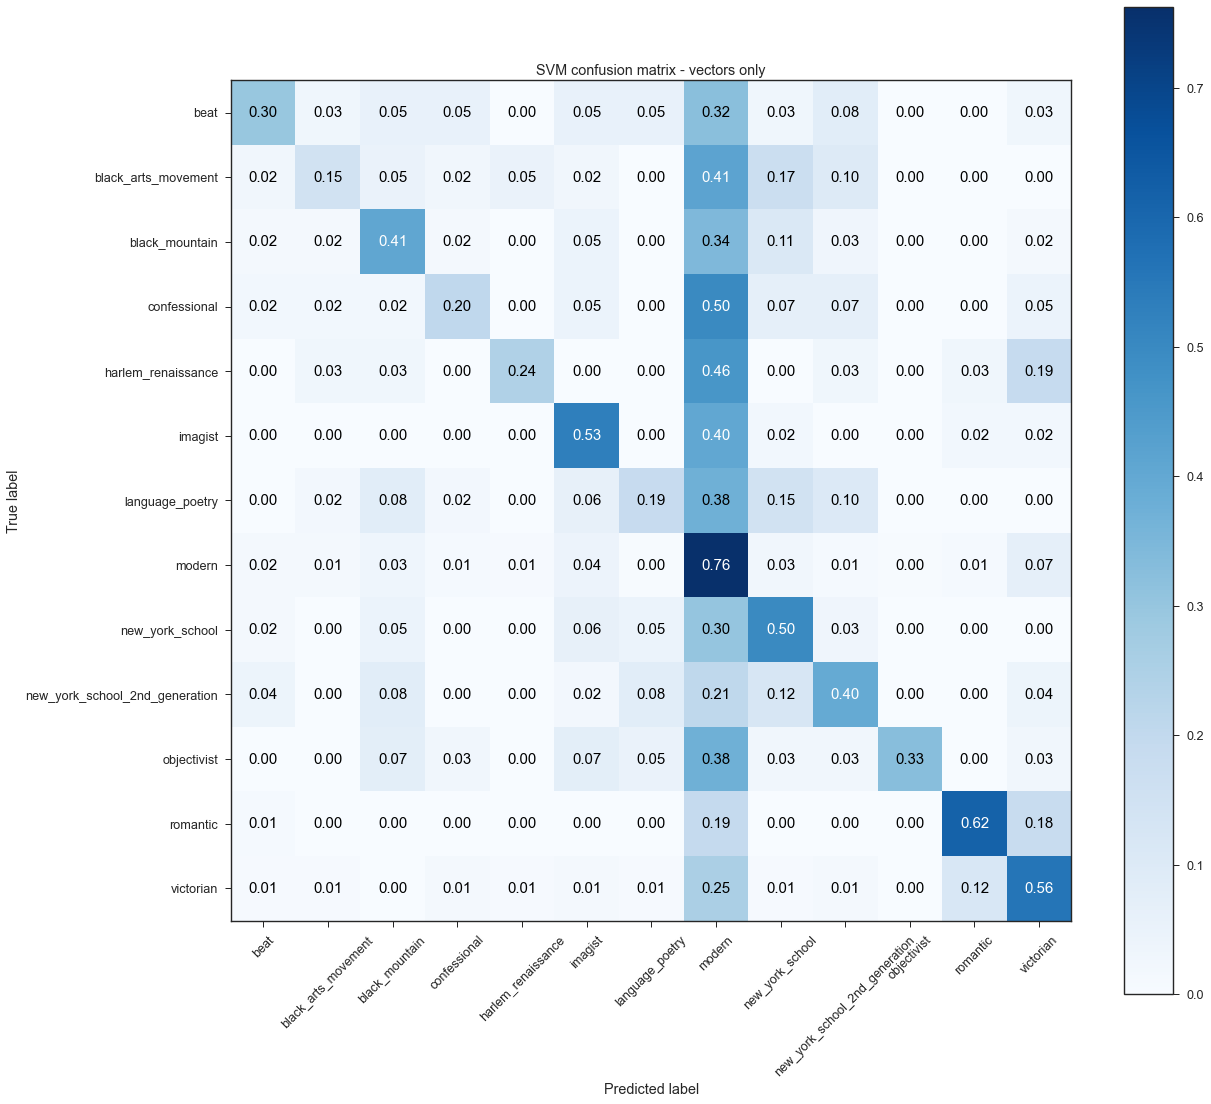

In [48]:
cm = confusion_matrix(y_test, y_test_preds_svm_vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix - vectors only',
                          cmap=plt.cm.Blues);

### Feature importances
- **Code credit: 'https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn'**

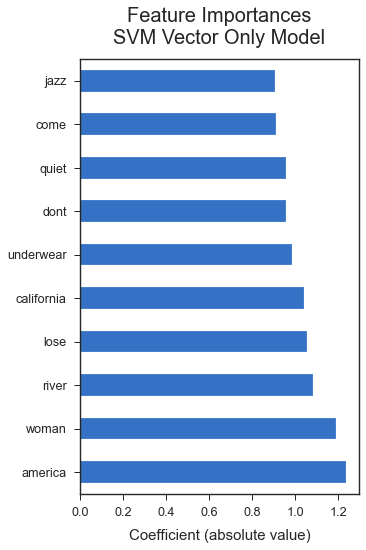

In [35]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Vector Only Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_vec.coef_[0]), index=X_train_vec.columns).nlargest(10).plot(kind='barh');

- **Quite a bump! very overfit, but I'll see if it works any better with our combo dataframes.**

## SVM - vectors + numerical data

In [36]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 13min 24s, sys: 3.34 s, total: 13min 27s
Wall time: 13min 29s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.926873857404022
F1 score: 0.9257412167873489

-----TEST-----
Accuracy: 0.5493601462522852
F1 score: 0.5387471709849813

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.44      0.30      0.35        37
           black_arts_movement       0.37      0.24      0.29        41
                black_mountain       0.40      0.55      0.46        64
                  confessional       0.44      0.16      0.23        44
            harlem_renaissance       0.61      0.30      0.40        37
                       imagist       0.51      0.66      0.58        89
               language_poetry       0.47      0.31      0.38        48
                        modern       0.59      0.68      0.63       320
               new_york_school       0.46      0.70      0.55        66
new_york_school_2nd_generatio

### Confusion matrix visualization

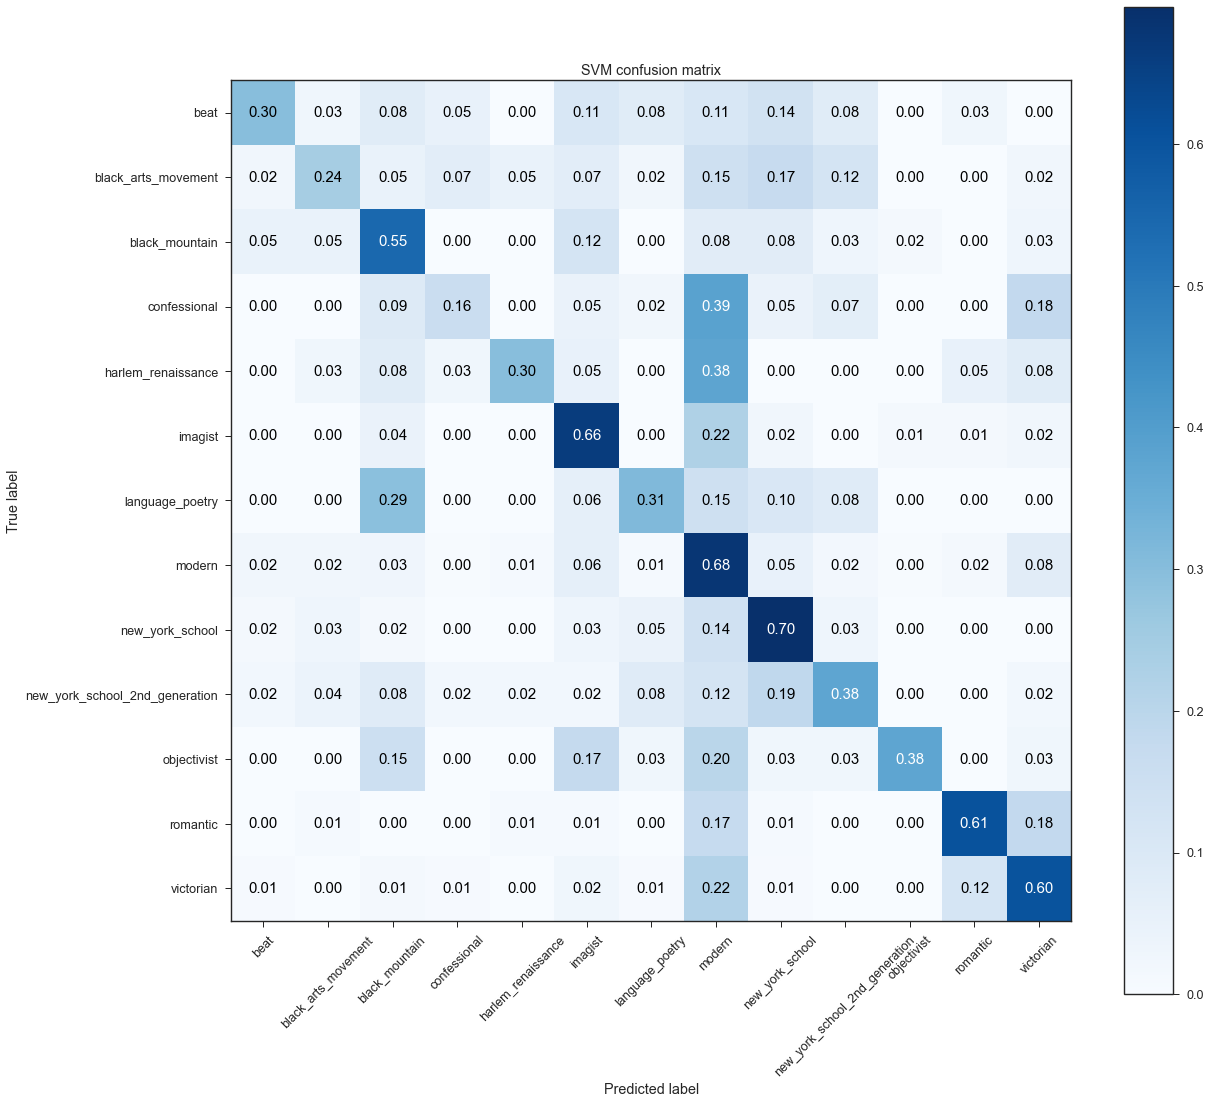

In [38]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

- **Still overfit but nearly a 10% increase in the test predictions!**

### Feature importances

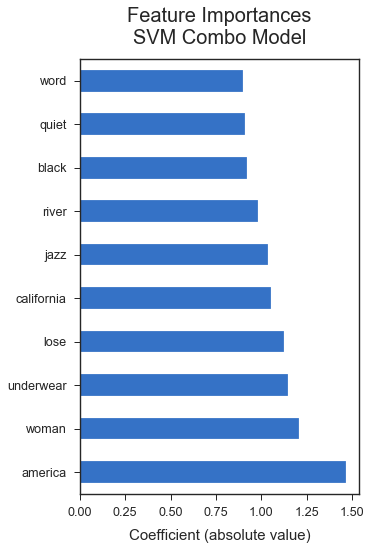

In [39]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [142]:
%%time

# instantiate the model
svm_combo2 = SVC(C=2, kernel='linear', class_weight='balanced', random_state=42)

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 17min 52s, sys: 9.65 s, total: 18min 2s
Wall time: 18min 27s


SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [143]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.9762340036563071
F1 score: 0.9761425098839991

-----TEST-----
Accuracy: 0.576782449725777
F1 score: 0.5583160101581542

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.60      0.32      0.42        37
           black_arts_movement       0.55      0.29      0.38        41
                black_mountain       0.46      0.48      0.47        64
                  confessional       0.44      0.16      0.23        44
            harlem_renaissance       0.71      0.27      0.39        37
                       imagist       0.59      0.60      0.59        89
               language_poetry       0.43      0.25      0.32        48
                        modern       0.57      0.80      0.66       320
               new_york_school       0.54      0.65      0.59        66
new_york_school_2nd_generatio

### Confusion matrix visualization

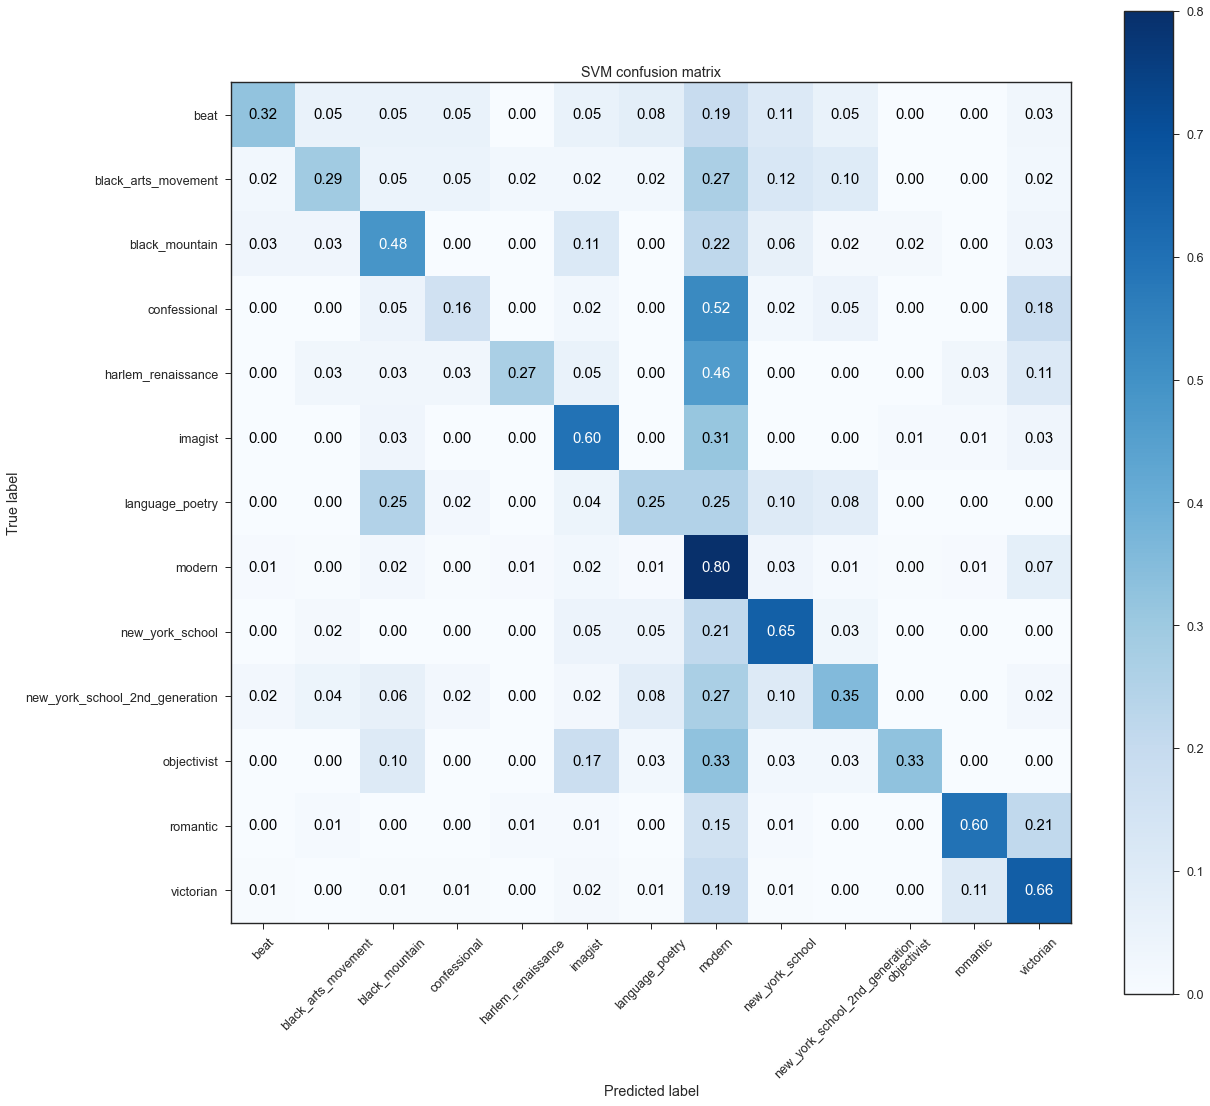

In [144]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

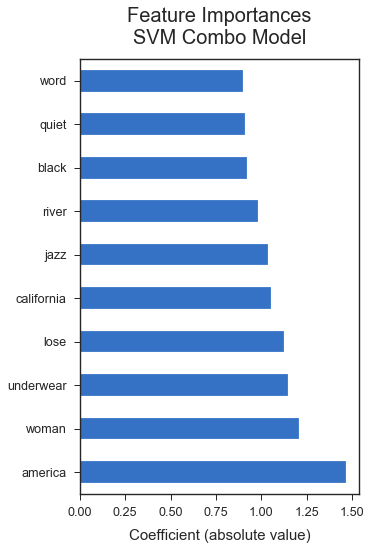

In [145]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [138]:
%%time

# instantiate the model
svm_combo2b = SVC(C=2.5, kernel='linear', class_weight='balanced',
#                   max_iter=100,
#                   decision_function_shape='ovo',
                  random_state=42)

# fit to the training set
svm_combo2b.fit(X_train_combo, y_train)

CPU times: user 15min 15s, sys: 6.34 s, total: 15min 21s
Wall time: 15min 28s


SVC(C=2.5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [139]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2b = svm_combo2b.predict(X_train_combo)
y_test_preds_svm_combo2b = svm_combo2b.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2b = accuracy_score(y_train, y_train_preds_svm_combo2b)
svm_combo_f1_train2b = f1_score(y_train, y_train_preds_svm_combo2b, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2b}')
print(f'F1 score: {svm_combo_f1_train2b}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2b = accuracy_score(y_test, y_test_preds_svm_combo2b)
svm_combo_f1_test2b = f1_score(y_test, y_test_preds_svm_combo2b, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2b}')
print(f'F1 score: {svm_combo_f1_test2b}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2b, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2b))

-----TRAIN-----
Accuracy: 0.9853747714808044
F1 score: 0.9853341445836077

-----TEST-----
Accuracy: 0.5694698354661791
F1 score: 0.5493375112311484

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.61      0.30      0.40        37
           black_arts_movement       0.52      0.27      0.35        41
                black_mountain       0.47      0.44      0.45        64
                  confessional       0.50      0.16      0.24        44
            harlem_renaissance       0.71      0.27      0.39        37
                       imagist       0.59      0.56      0.57        89
               language_poetry       0.41      0.23      0.29        48
                        modern       0.54      0.81      0.65       320
               new_york_school       0.56      0.62      0.59        66
new_york_school_2nd_generati

### Confusion matrix visualization

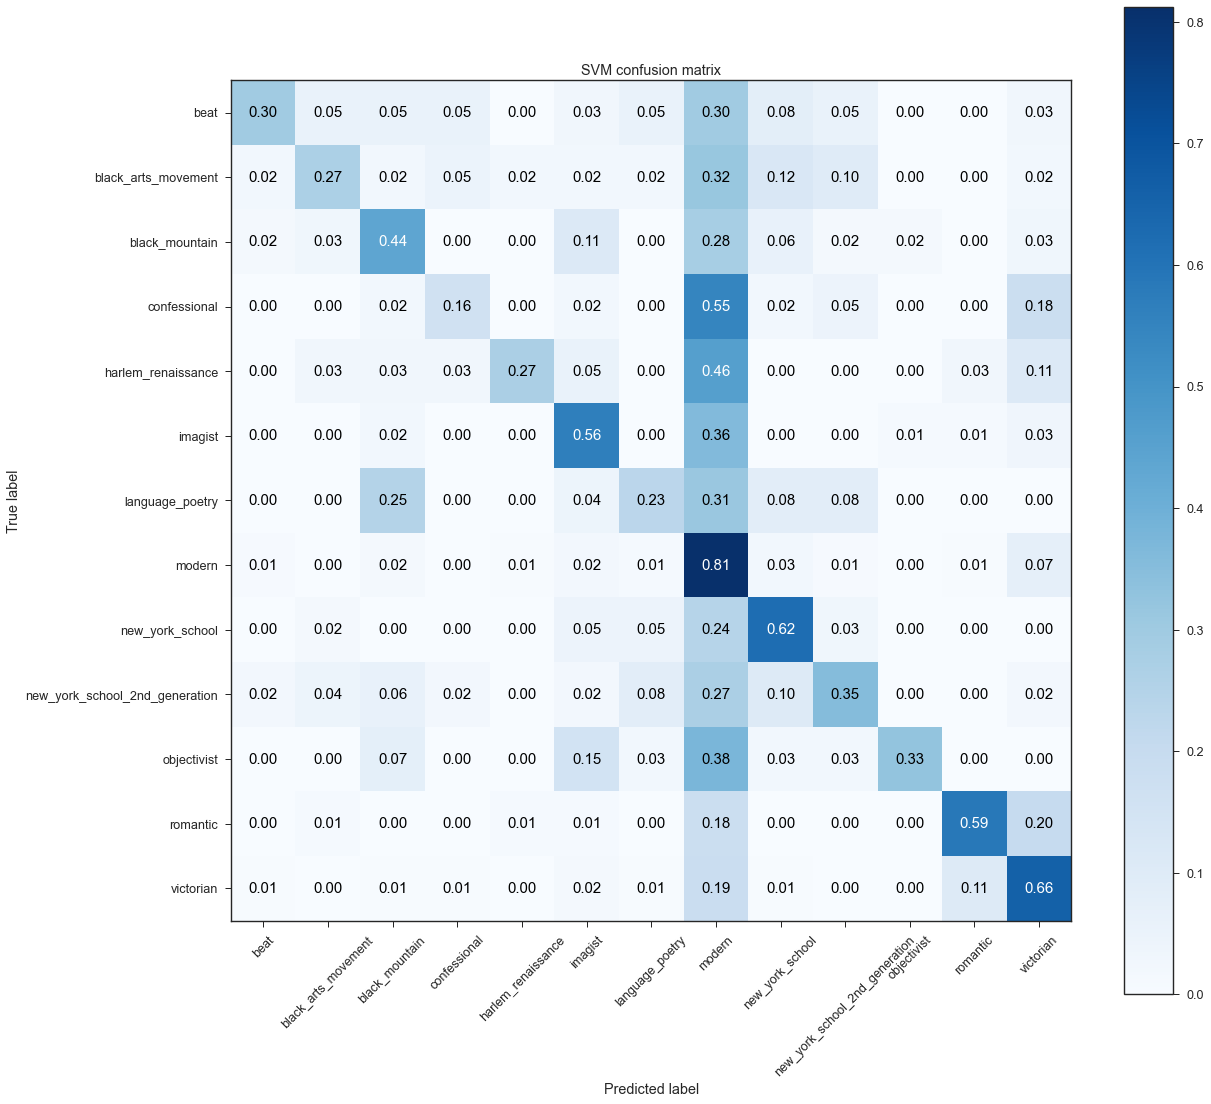

In [140]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2b)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

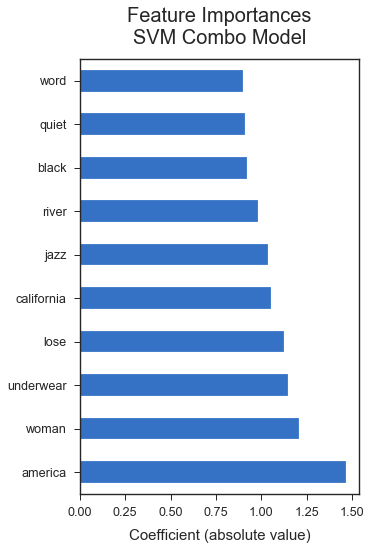

In [141]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2b.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

In [65]:
# rec system libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import matutils, models
from gensim.utils import simple_preprocess

In [66]:
# load the model
model = Doc2Vec.load('data/doc2vec.model')

In [68]:
len(model[0])

100

In [86]:
model.docvecs[4375]

array([ 1.2006652 ,  0.08307341,  0.07383984, -3.7577698 , -1.3732673 ,
       -1.9492179 , -0.51855606,  1.2757812 , -2.1541429 ,  3.6966357 ,
       -0.9324427 , -3.3933728 ,  2.2591443 ,  2.1146212 , -0.8617075 ,
        1.9893605 ,  1.5804762 , -2.7629943 , -3.7851126 , -1.65619   ,
       -3.0771718 , -0.3890964 ,  2.676029  , -3.1462984 , -2.6133223 ,
       -5.2887487 ,  2.533953  , -2.0680223 , -1.4912119 ,  0.85219496,
       -2.4538805 , -1.968039  , -2.1103768 , -0.65240467, -3.256561  ,
       -0.22674862,  2.5130308 ,  1.5527182 , -0.7872084 ,  0.7285329 ,
       -0.7509936 ,  2.138676  ,  1.6633475 , -4.313129  ,  5.2023277 ,
        1.6293415 ,  1.5118138 , -4.0869627 ,  0.6913048 , -3.5921793 ,
        4.4061847 , -0.24334763,  0.9060332 , -0.96803534, -0.6498659 ,
       -1.4631542 ,  1.2633619 , -1.8299843 , -2.6928277 ,  0.9119264 ,
       -2.4688904 , -4.9157147 , -0.19808227,  0.21045764, -3.4096267 ,
       -2.8473542 ,  4.5900426 , -5.4284616 , -2.899884  , -0.95

In [92]:
df.tail()

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string,clean_lines,num_lines,num_words,...,sentiment_subjectivity_score,num_end_rhymes,end_rhyme_ratio,end_rhyme,num_syllables,avg_syllables_word,lines_titled,string_titled,string_cleaned,doc2vec
4371,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45490/snow-bound-a-winter-idyl,John Greenleaf Whittier,Snow-Bound: A Winter Idyl,"[The sun that brief December day , Rose cheerless over hills of gray, , And, darkly circled, gave at noon , A sadder light than waning moon. , Slo...","The sun that brief December day \nRose cheerless over hills of gray, \nAnd, darkly circled, gave at noon \nA sadder light than waning moon. \nSlow...","[The sun that brief December day, Rose cheerless over hills of gray,, And, darkly circled, gave at noon, A sadder light than waning moon., Slow tr...",90,700,...,0.502497,50,4.199472,1,5632,1.209103,"[Snow-Bound: A Winter Idyl, The sun that brief December day, Rose cheerless over hills of gray,, And, darkly circled, gave at noon, A sadder light...","Snow-Bound: A Winter Idyl The sun that brief December day Rose cheerless over hills of gray, And, darkly circled, gave at noon A sadder light than...",snow bound winter idyl sun brief december day rise cheerless hill gray darkly circle give noon sadder light wan moon slow trace thicken sky mute o...,"Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t8)"
4372,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45491/telling-the-bees,John Greenleaf Whittier,Telling the Bees,"[Here is the place; right over the hill , Runs the path I took; , You can see the gap in the old wall still, , And the stepping-stones in th...","Here is the place; right over the hill \n Runs the path I took; \nYou can see the gap in the old wall still, \n And the stepping-stones in the...","[Here is the place; right over the hill, Runs the path I took;, You can see the gap in the old wall still,, And the stepping-stones in the shallow...",56,393,...,0.388294,36,0.642857,1,426,1.083969,"[Telling the Bees, Here is the place; right over the hill, Runs the path I took;, You can see the gap in the old wall still,, And the stepping-sto...","Telling the Bees Here is the place; right over the hill Runs the path I took; You can see the gap in the old wall still, And the stepping-stones i...",tell bee place right hill run path take see gap old wall still step stone shallow brook house gate red bar poplar tall barn brown length cattle ya...,"Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t8)"
4373,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45492/what-the-birds-said,John Greenleaf Whittier,What the Birds Said,"[The birds against the April wind\r, Flew northward, singing as they flew;\r, They sang, “The land we leave behind\r, Has swords for corn-blad...","The birds against the April wind\r\n Flew northward, singing as they flew;\r\nThey sang, “The land we leave behind\r\n Has swords for corn-blade...","[The birds against the April wind, Flew northward, singing as they flew;, They sang, “The land we leave behind, Has swords for corn-blades, blood ...",44,279,...,0.569830,18,0.409091,1,326,1.168459,"[What the Birds Said, The birds against the April wind, Flew northward, singing as they flew;, They sang, “The land we leave behind, Has swords fo...","What the Birds Said The birds against the April wind Flew northward, singing as they flew; They sang, “The land we leave behind Has swords for cor...",bird say bird april wind flew northward sing flew sang land leave behind sword corn blade blood dew wild bird fly south saw heard gaze saw mortar ...,"Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t8)"
4374,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45493/the-worship-of-nature,John Greenleaf Whittier,The Worship of Nature,"[The harp at Na

In [93]:
df['doc2vec'] = [model[i] for i in range(len(df))]
df.doc2vec.head()

0    [2.2810318, -1.3713742, -2.2196689, -5.0615764, 0.3864901, 0.41665703, 1.3406408, -1.5597857, -0.31412253, -0.4657635, -2.411453, 0.08069745, 1.33...
1    [2.1657145, -2.0169647, 2.2267005, -2.0562868, -1.5337021, -3.544704, 0.543327, 1.4363956, -3.0137055, 1.9207215, 1.6236316, -4.414039, 1.7481873,...
2    [-0.8471292, -3.5684974, 1.7660245, -0.7075871, 0.1878668, -2.0000925, 3.5216043, 1.8281693, 3.78491, 1.7794362, 1.1803681, 0.5493797, 4.158774, -...
3    [-5.168643, -1.8557563, 1.6146945, -3.8942952, 1.6658205, -0.19298406, 1.7390785, -1.5401896, 3.028075, 0.37988093, -1.8792233, -1.4851906, -1.698...
4    [-1.2178899, 1.3043916, -2.8433595, -2.121003, 3.0231776, 0.6782006, 2.7962484, 2.6654553, 2.2535207, 2.3527656, 0.16284443, -2.3561792, 0.7265119...
Name: doc2vec, dtype: object

In [91]:
model.dm_tag_count

1

In [94]:
df_vecs = pd.DataFrame(np.vstack(model[i] for i in range(len(df))))
df_vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.281032,-1.371374,-2.219669,-5.061576,0.386490,0.416657,1.340641,-1.559786,-0.314123,-0.465764,...,0.914341,-0.042474,-1.413320,3.378504,-0.387815,-0.327874,-0.029154,1.119749,2.482635,-2.202907
1,2.165715,-2.016965,2.226701,-2.056287,-1.533702,-3.544704,0.543327,1.436396,-3.013705,1.920722,...,-2.519491,-1.564618,2.388425,-3.334627,-2.866033,2.925122,-1.246679,0.222634,-2.713806,-0.705287
2,-0.847129,-3.568497,1.766024,-0.707587,0.187867,-2.000093,3.521604,1.828169,3.784910,1.779436,...,-1.003638,1.122231,3.063076,-0.517507,-0.472288,1.351467,-1.488940,1.042941,0.121341,0.073162
3,-5.168643,-1.855756,1.614694,-3.894295,1.665820,-0.192984,1.739079,-1.540190,3.028075,0.379881,...,-0.311557,-3.424692,0.067995,3.414546,0.398550,-0.784360,-2.558453,3.444434,-1.373973,-2.202393
4,-1.217890,1.304392,-2.843359,-2.121003,3.023178,0.678201,2.796248,2.665455,2.253521,2.352766,...,-0.483795,1.881845,-1.505026,-1.484471,-2.559262,-1.319453,-0.751955,2.392272,-0.071207,-1.690263


In [87]:
df.shape

(4376, 23)

In [117]:
# assign a features dataframe
X2 = pd.concat([df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_cleaned']], df_vecs], axis=1)
# assign a target variable
y2 = df['genre']

In [118]:
X2.head()

,num_lines,avg_len_line,sentiment_polarity_score,sentiment_subjectivity_score,num_end_rhymes,avg_syllables_word,string_cleaned,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,4,6.000000,0.1779,0.680952,0,1.083333,california institute technology care god damn smart guy bore rain hell day long nothing,2.281032,-1.371374,-2.219669,...,0.914341,-0.042474,-1.413320,3.378504,-0.387815,-0.327874,-0.029154,1.119749,2.482635,-2.202907
1,17,2.647059,-0.4588,0.512698,0,1.266667,boat beautiful werewolf evil forest take carnival start cry saw ferris wheel electric green red tear flow furry cheek look boat dark water,2.165715,-2.016965,2.226701,...,-2.519491,-1.564618,2.388425,-3.334627,-2.866033,2.925122,-1.246679,0.222634,-2.713806,-0.705287
2,6,5.500000,0.3612,0.288889,1,1.242424,december morning fart smell marriage avocado fish head get bed write without glass,-0.847129,-3.568497,1.766024,...,-1.003638,1.122231,3.063076,-0.517507,-0.472288,1.351467,-1.488940,1.042941,0.121341,0.073162
3,17,3.176471,0.3506,0.787500,0,1.240741,double bed dream gallows drive hot brushy country late autumn saw hawk crucify barbed wire fence guess kind advertisement hawk say page lead woman...,-5.168643,-1.855756,1.614694,...,-0.311557,-3.424692,0.067995,3.414546,0.398550,-0.784360,-2.558453,3.444434,-1.373973,-2.202393
4,4,3.250000,0.0000,0.150000,0,1.230769,haiku ambulance piece green pepper fell wooden salad bowl,-1.217890,1.304392,-2.843359,...,-0.483795,1.881845,-1.505026,-1.484471,-2.559262,-1.319453,-0.751955,2.392272,-0.071207,-1.690263


In [162]:
X2.shape

(4376, 107)

In [146]:
# train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, random_state=42)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

[autoreload of six failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 327, in update_class
    old_obj = getattr(old, key)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of google.protobuf.descriptor_pool failed: Traceback (most recent call last):

(3282, 107) (3282,)
(1094, 107) (1094,)


In [147]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train2.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test2.string_cleaned)

In [168]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_word_vecs = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, index=X_train2.index, columns=vectorizer.get_feature_names())
X_test_word_vecs = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, index=X_test2.index, columns=vectorizer.get_feature_names())

In [153]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train2.iloc[:, :6])
X_test_scaled = scaler.transform(X_test2.iloc[:, :6])

In [172]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train2.index, columns=X_train2.iloc[:, :6].columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test2.index, columns=X_test2.iloc[:, :6].columns) 

In [174]:
X_train_ultra = pd.concat([X_train_scaled_df, X_train2.iloc[:, 7:], X_train_word_vecs], ignore_index=True, axis=1)
X_test_ultra = pd.concat([X_test_scaled_df, X_test2.iloc[:, 7:], X_test_word_vecs], axis=1)

X_train_ultra.shape, X_test_ultra.shape

((3282, 29120), (1094, 29120))

In [175]:
%%time

# instantiate the model
svm_doc2vec = SVC(C=1, kernel='linear', class_weight='balanced')

# fit to the training set
svm_doc2vec.fit(X_train_ultra, y_train2)

CPU times: user 8min 55s, sys: 2 s, total: 8min 57s
Wall time: 8min 57s


SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [176]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec = svm_doc2vec.predict(X_train_ultra)
y_test_preds_svm_doc2vec = svm_doc2vec.predict(X_test_ultra)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train = accuracy_score(y_train2, y_train_preds_svm_doc2vec)
svm_doc2vec_f1_train = f1_score(y_train2, y_train_preds_svm_doc2vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train}')
print(f'F1 score: {svm_doc2vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test = accuracy_score(y_test2, y_test_preds_svm_doc2vec)
svm_doc2vec_f1_test = f1_score(y_test2, y_test_preds_svm_doc2vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test}')
print(f'F1 score: {svm_doc2vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test2, y_test_preds_svm_doc2vec, target_names=list(y2.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test2, y_test_preds_svm_doc2vec))

-----TRAIN-----
Accuracy: 0.8732480195003047
F1 score: 0.8683961755083822

-----TEST-----
Accuracy: 0.44881170018281535
F1 score: 0.4595855959527148

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.14      0.19      0.16        37
           black_arts_movement       0.23      0.27      0.25        41
                black_mountain       0.31      0.39      0.34        64
                  confessional       0.19      0.27      0.22        44
            harlem_renaissance       0.16      0.27      0.20        37
                       imagist       0.41      0.51      0.45        89
               language_poetry       0.36      0.29      0.32        48
                        modern       0.58      0.48      0.52       320
               new_york_school       0.44      0.35      0.39        66
new_york_school_2nd_generat

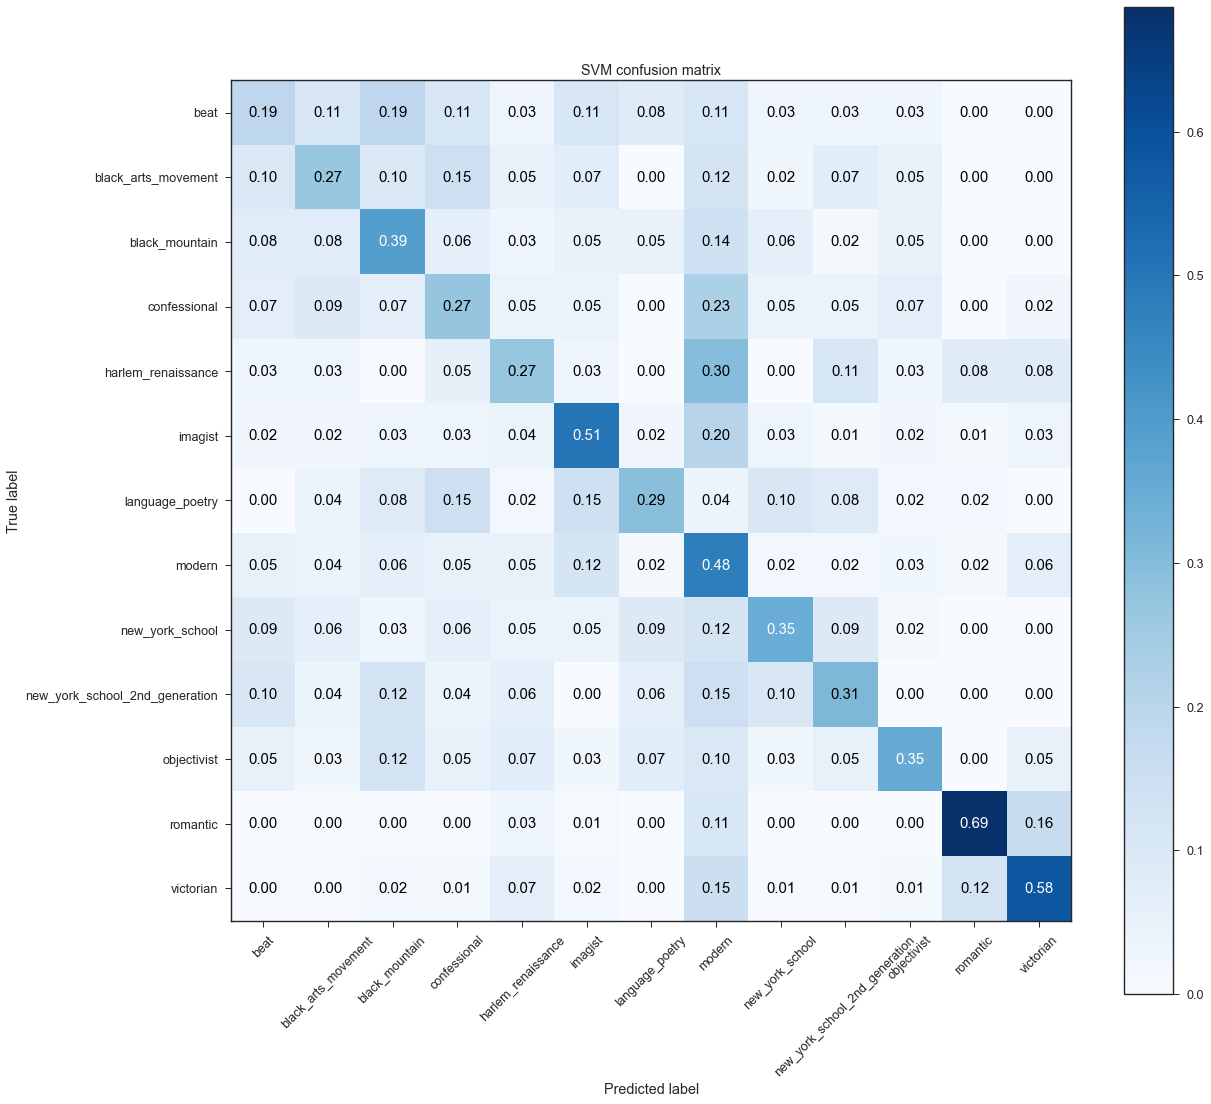

In [177]:
cm = confusion_matrix(y_test2, y_test_preds_svm_doc2vec)
classes = y2.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

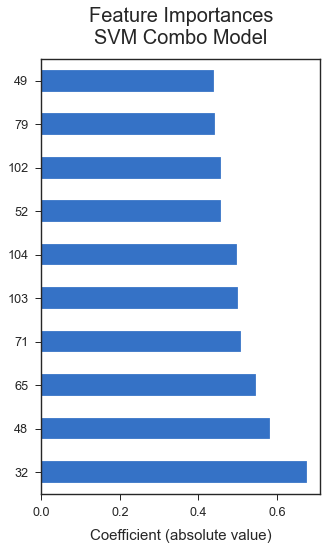

In [178]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc2vec.coef_[0]), index=X_train_ultra.columns).nlargest(10).plot(kind='barh');

In [207]:
%%time

# instantiate the model
svm_doc2vec_tuned = SVC(C=9, kernel='linear', class_weight='balanced')

# fit to the training set
svm_doc2vec_tuned.fit(X_train_ultra, y_train2)

CPU times: user 9min 48s, sys: 2.92 s, total: 9min 51s
Wall time: 9min 58s


SVC(C=9, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [208]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec_tuned = svm_doc2vec_tuned.predict(X_train_ultra)
y_test_preds_svm_doc2vec_tuned = svm_doc2vec_tuned.predict(X_test_ultra)

# print out accuracy and f1 scores for train set
svm_doc2vec_tuned_acc_train = accuracy_score(y_train2, y_train_preds_svm_doc2vec_tuned)
svm_doc2vec_tuned_f1_train = f1_score(y_train2, y_train_preds_svm_doc2vec_tuned, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_tuned_acc_train}')
print(f'F1 score: {svm_doc2vec_tuned_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc2vec_tuned_acc_test = accuracy_score(y_test2, y_test_preds_svm_doc2vec_tuned)
svm_doc2vec_tuned_f1_test = f1_score(y_test2, y_test_preds_svm_doc2vec_tuned, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_tuned_acc_test}')
print(f'F1 score: {svm_doc2vec_tuned_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test2, y_test_preds_svm_doc2vec_tuned, target_names=list(y2.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test2, y_test_preds_svm_doc2vec_tuned))

-----TRAIN-----
Accuracy: 0.9990859232175503
F1 score: 0.9990868712911755

-----TEST-----
Accuracy: 0.5146252285191956
F1 score: 0.5059875907803495

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.17      0.16      0.17        37
           black_arts_movement       0.18      0.17      0.18        41
                black_mountain       0.38      0.39      0.39        64
                  confessional       0.30      0.30      0.30        44
            harlem_renaissance       0.25      0.22      0.23        37
                       imagist       0.57      0.44      0.49        89
               language_poetry       0.34      0.31      0.33        48
                        modern       0.56      0.76      0.64       320
               new_york_school       0.43      0.35      0.39        66
new_york_school_2nd_generati

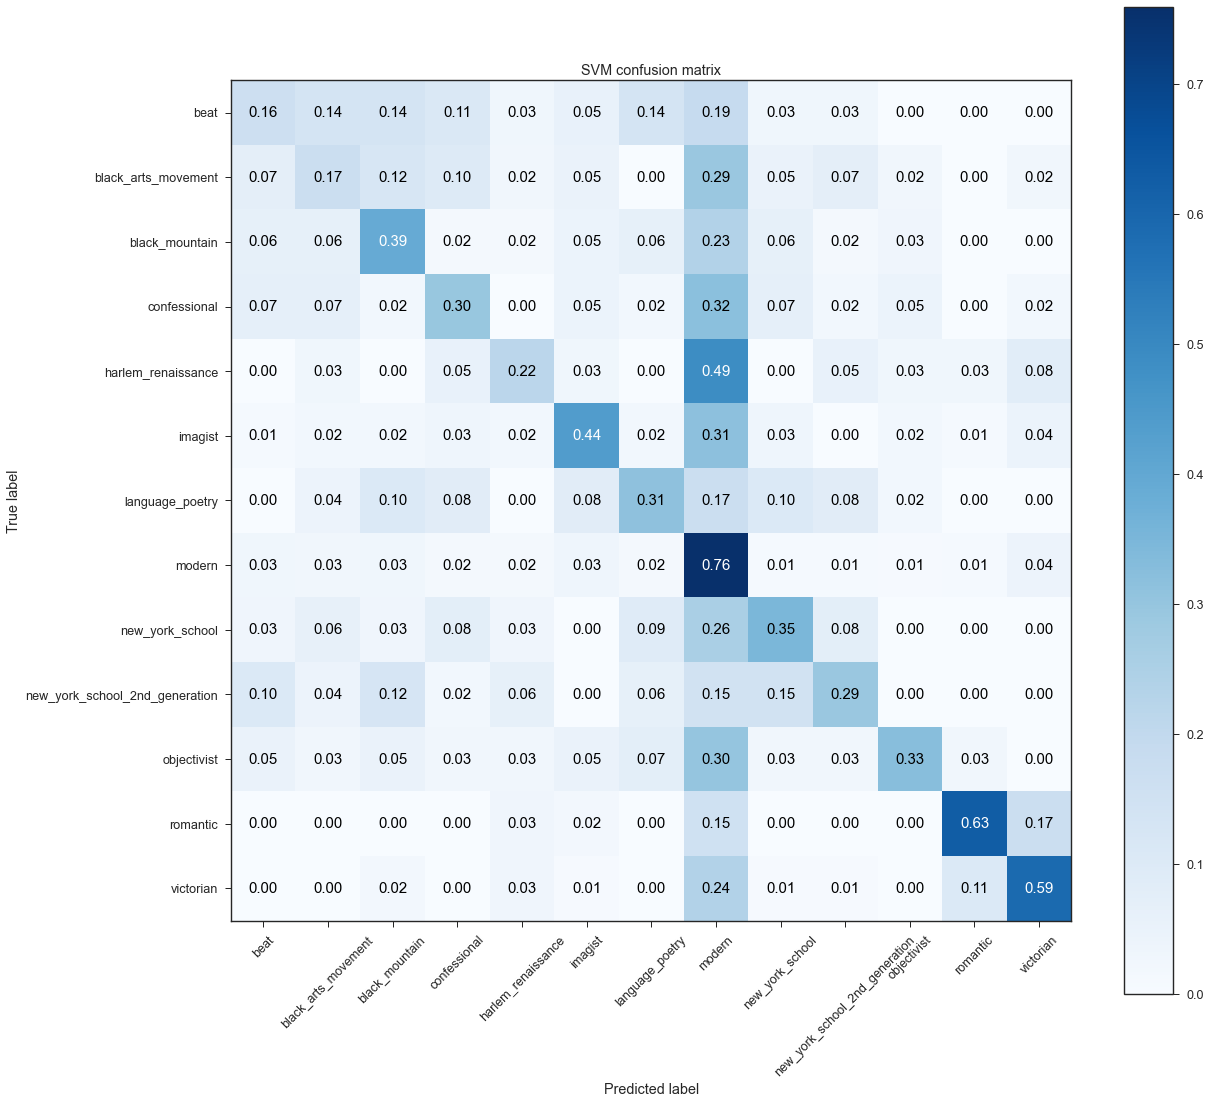

In [209]:
cm = confusion_matrix(y_test2, y_test_preds_svm_doc2vec_tuned)
classes = y2.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

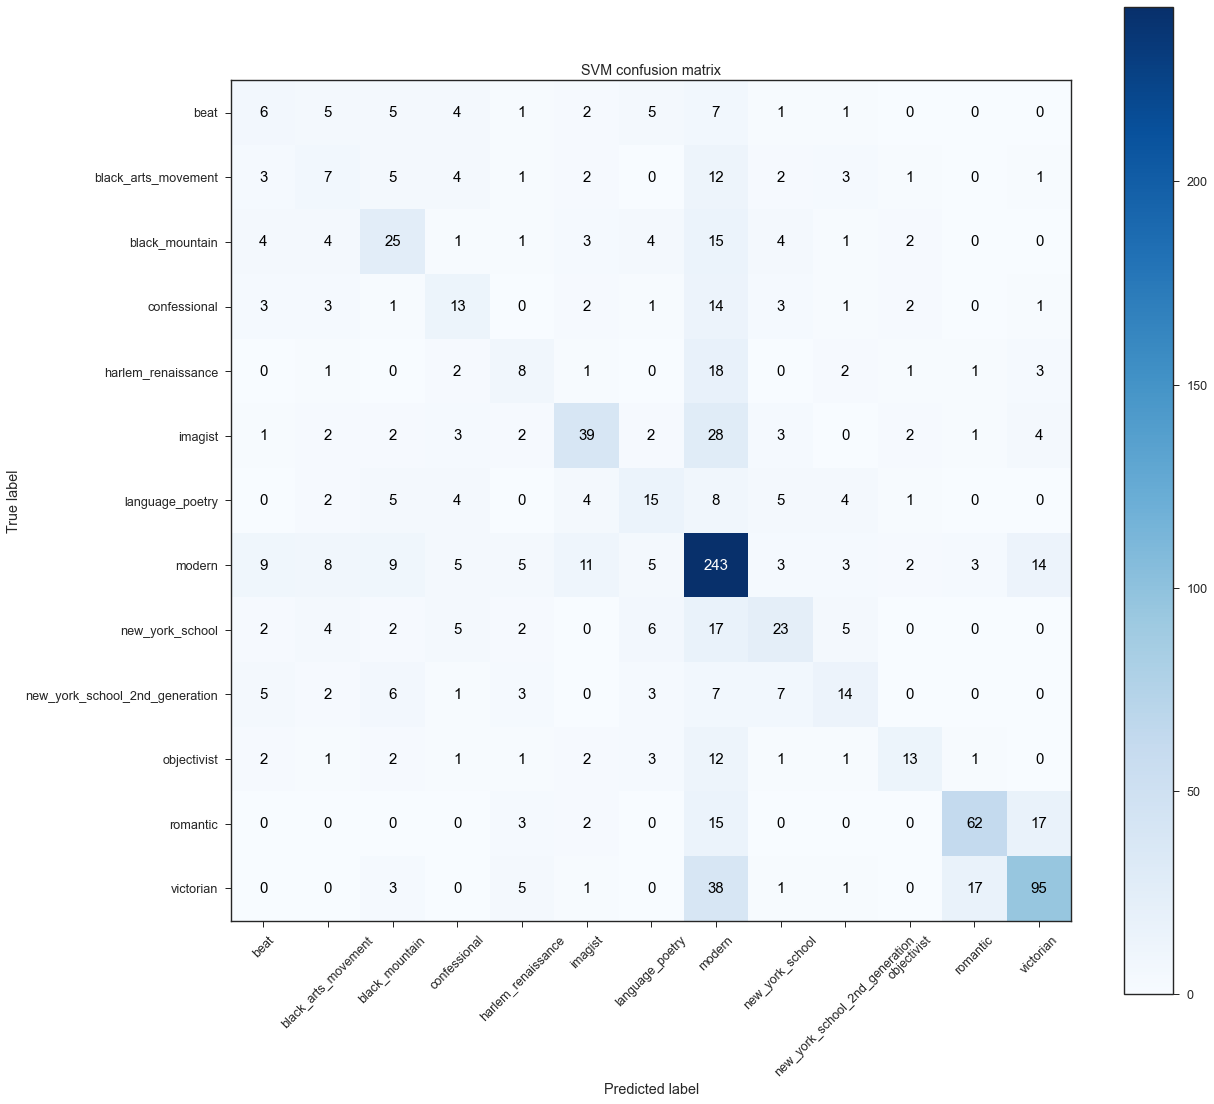

In [210]:
cm = confusion_matrix(y_test2, y_test_preds_svm_doc2vec_tuned)
classes = y2.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

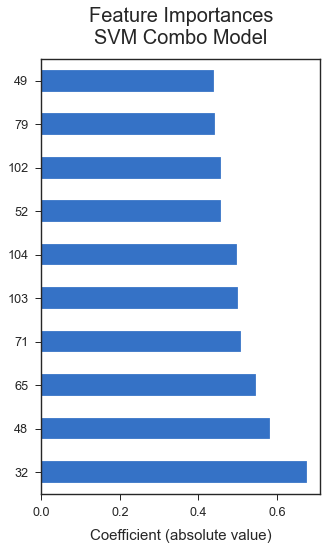

In [211]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc2vec_tuned.coef_[0]), index=X_train_ultra.columns).nlargest(10).plot(kind='barh');